In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pyteomics.auxiliary
import pyteomics.fasta
import seaborn as sns
import tqdm
from chembl_webresource_client.new_client import new_client as chembl_client

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
tqdm.tqdm.pandas()

# Investigation of SARS-CoV-2 viral-host protein-protein interactions

This notebook forms a brief tutorial of the computational steps needed to analyze affinity purification mass spectrometry (AP-MS) data to detect protein-protein interactions (PPIs).

We will reanalyze AP-MS data generated by [Gordon et al.](https://doi.org/10.1038/s41586-020-2286-9) to investigate the SARS-CoV-2 viral-host interactome.

## Download data

First, we download the raw SARS-CoV-2 AP-MS data from PRIDE with project number [PXD018117](https://www.ebi.ac.uk/pride/archive/projects/PXD018117). 

In [3]:
%%bash

if [ ! -d ../data/external/PXD018117 ]; then
    wget --timestamping --retry-connrefused \
        --directory-prefix=../data/external/PXD018117 --passive-ftp \
        ftp://ftp.pride.ebi.ac.uk/pride/data/archive/2020/03/PXD018117/*
fi

## Spectrum identification

After downloading the data, we will first convert the RAW files to MGF files using [ThermoRawFileParser](https://github.com/compomics/ThermoRawFileParser) for easy cross-platform analysis.

In [4]:
%%bash

mkdir -p ../data/interim/PXD018117

for raw_file in ../data/external/PXD018117/*.raw; do
    if [ ! -f ../data/interim/PXD018117/$(basename $raw_file .raw).mgf ]; then
        mono /home/wout/.conda/envs/sars_cov_2/bin/ThermoRawFileParser.exe \
            -i $raw_file -o ../data/interim/PXD018117 -f 0
    fi
done

The AP-MS data contains spectra corresponding to three different species: human, SARS-CoV-2, and green fluorescent protein (tag used for AP-MS). The corresponding three FASTA files downloaded from PRIDE will be concatenated into a single FASTA file.

In [5]:
! cat ../data/external/PXD018117/*.fasta > ../data/interim/PXD018117/human_GFP_SARSCoV2.fasta

Next, we identify the MS/MS spectra using sequence database searching. We use the [Comet](http://comet-ms.sourceforge.net/) search engine via the [Crux](http://crux.ms/) toolkit.

The following settings are used for spectral identification:

- Concatenated target-decoy search.
- 10 _m_/_z_ precursor mass tolerance.
- Trypsin/P cleavage.
- Remove precursor peak.
- Only report the top scoring peptide per spectrum.
- All other settings were kept at their [default values](http://crux.ms/commands/comet.html).

In [6]:
%%bash

for mgf_file in ../data/interim/PXD018117/*.mgf; do
    if [ ! -f ../data/processed/PXD018117/$(basename $mgf_file .mgf).comet.target.txt ]; then
        crux comet $mgf_file ../data/interim/PXD018117/human_GFP_SARSCoV2.fasta \
            --decoy_search 1 --peptide_mass_tolerance 10 --peptide_mass_units 2 \
            --search_enzyme_number 2 --remove_precursor_peak 1 \
            --fileroot $(basename $mgf_file .mgf) \
            --output-dir ../data/processed/PXD018117 --output_pepxmlfile 0 \
            --num_output_lines 1
    fi
done

## PPI generation

We will filter the peptide-spectrum matches (PSMs) at 1% FDR using [Pyteomics](https://pyteomics.readthedocs.io/en/latest/) and use those identifications to detect high-confidence PPIs using the [SAINTexpress](saint-apms.sourceforge.net/Main.html) tool.

### Filter PSMs on FDR

First all PSMs are read from the different Comet output files and they are jointly filtered at 1% FDR.

In [7]:
psm_fdr = protein_fdr = 0.01

In [8]:
# Read all PSMs from the Comet output files into a Pandas data frame.
psms = []
id_dir = '../data/processed/PXD018117'
for filename in os.listdir(id_dir):
    if filename.endswith('comet.target.txt'):
        file_psms = pd.read_csv(
            os.path.join(id_dir, filename), sep='\t',
            usecols=['xcorr score', 'sequence', 'protein id'])
        file_psms['filename'] = filename[:filename.find('.')]
        psms.append(file_psms)
psms = pd.concat(psms, ignore_index=True)

In [9]:
# Add protein information to the PSMs and split per individual proteins.
psms['protein id'] = psms['protein id'].str.split(',')
psms = psms.explode('protein id')
psms['is_decoy'] = psms['protein id'].str.startswith('decoy_')
psms['protein_short'] = [protein[1] if len(protein) > 1 else protein[0]
                         for protein in psms['protein id'].str.split('|')]
print(f'Number of PSMs before FDR filtering: {len(psms):,}')
# PSM-level FDR filtering.
psms_filtered = pyteomics.auxiliary.target_decoy.filter(
    psms, fdr=psm_fdr, key='xcorr score', reverse=True, is_decoy='is_decoy',
    remove_decoy=False, formula=1, correction=1)
print(f'Number of PSMs after PSM-level FDR filtering: '
      f'{len(psms_filtered):,}')
# Protein-level FDR filtering.
proteins = (psms_filtered.groupby('protein id')['xcorr score'].max()
            .reset_index())
proteins['is_decoy'] = proteins['protein id'].str.startswith('decoy_')
proteins_filtered = pyteomics.auxiliary.target_decoy.filter(
    proteins, fdr=protein_fdr, key='xcorr score', reverse=True,
    is_decoy='is_decoy', formula=1, correction=1)
psms_filtered = psms_filtered[psms_filtered['protein id'].isin(
    proteins_filtered['protein id'].unique())]
print(f'Number of PSMs after protein-level FDR filtering: '
      f'{len(psms_filtered):,}')

Number of PSMs before FDR filtering: 2,618,837
Number of PSMs after PSM-level FDR filtering: 207,909
Number of PSMs after protein-level FDR filtering: 198,164


### Generate SAINTexpress input files

SAINTexpress requires three tab-separated text input files: a bait file, a prey, and an interaction file.

In [10]:
sample_annotation = pd.read_excel(
    '../data/external/PXD018117/SARS ProteomeXchange Upload Sample Annotations.xlsx',
    index_col='QX raw file ID')

The bait file should have three columns: run name, bait name, and an indicator whether the run was a test (T) or negative control (C) run. We extract this information from the experiment metadata spreadsheet downloaded from PRIDE and export this to a text file.

In [11]:
columns = ['Sample ID', 'Condition', 'Control (C), or SARS-CoV-2 Bait (T)']
baits = (sample_annotation.sort_values(columns)[columns]
         .rename(columns={'Sample ID': 'run_name',
                          'Condition': 'bait_name',
                          'Control (C), or SARS-CoV-2 Bait (T)': 'run_type'}))
baits.to_csv('../data/processed/bait.txt', sep='\t', header=False, index=False)
baits.reset_index(drop=True).head()

,run_name,bait_name,run_type
0,CoV01-002_H11,E,T
1,CoV01-003_H10,M,T
2,CoV01-004_H9,N,T
3,CoV01-005_H8,orf3a,T
4,CoV01-006_H7,orf6,T


The prey file should have three columns: prey (protein) name, protein length, and gene name. To create a relevant prey file we extract the protein information from the previously downloaded human FASTA file using Pyteomics, filter this to only include information for the proteins that have been identified, and export this to a text file.

In [12]:
preys = []
for filename in ['uniprot-reviewed-human-canonical-20200228.fasta',
                 'GFP.fasta']:
    for header, sequence in pyteomics.fasta.read(
            os.path.join('../data/external/PXD018117/', filename),
            flavor='uniprot'):
        preys.append([header['id'], len(sequence), header.get('GN', header['gene_id'])])
proteins_sars_cov_2 = []
for header, sequence in pyteomics.fasta.read(
        '../data/external/PXD018117/SARS-CoV-2_FASTA_20200305.fasta'):
    preys.append([header, len(sequence), header[header.rfind('_') + 1:]])
    proteins_sars_cov_2.append(header[header.rfind('_') + 1:])
preys = (pd.DataFrame(preys, columns=['prey_name', 'protein_length', 'gene'])
         .set_index('prey_name')
         .reindex(psms_filtered['protein_short'].unique())
         .reset_index().sort_values('prey_name').dropna())
preys['protein_length'] = preys['protein_length'].astype(int)
preys.to_csv('../data/processed/prey.txt', sep='\t', header=False, index=False)
preys.reset_index(drop=True).head()

,prey_name,protein_length,gene
0,A0A0U1RRE5,68,NBDY
1,A0A0U1RRL7,71,MMP24OS
2,A0A1B0GUS4,154,UBE2L5
3,A0FGR8,921,ESYT2
4,A0JLT2,244,MED19


The interaction file should contain four columns: run name, bait name, prey name, and label-free quantification (LFQ) data. The run names and the bait names should match the run names and the bait names in the first two columns of the bait file and the prey names should match the prey names in the first column of the prey file. For the LFQ data we will use spectral counts, i.e. how many MS/MS spectra that were identified map to the proteins. The interaction file should not contain interactions with zero counts.

In [13]:
inter = (psms_filtered.groupby(['filename', 'protein_short'])
         ['protein_short'].count().to_frame()
         .rename(columns={'protein_short': 'count'})
         .reset_index()
         .rename(columns={'protein_short': 'prey_name'}))
inter = (pd.merge(inter, baits[['run_name', 'bait_name']],
                  left_on='filename', right_index=True)
         [['run_name', 'bait_name', 'prey_name', 'count']]
         .sort_values(['run_name', 'bait_name', 'prey_name']))
# Remove the baits themselves as preys.
inter = inter[~inter.apply(
    lambda row: row['prey_name'].split('_')[-1].endswith(
        row['bait_name'].split('_')[0]), axis=1)]
inter.to_csv('../data/processed/inter.txt', sep='\t', header=False, index=False)
inter.reset_index(drop=True).head()

,run_name,bait_name,prey_name,count
0,CoV01-002_H11,E,A5A3E0,1
1,CoV01-002_H11,E,A6NHL2,1
2,CoV01-002_H11,E,A6NNZ2,2
3,CoV01-002_H11,E,B2RPK0,1
4,CoV01-002_H11,E,O00203,1


### Filter PPIs using SAINT

Next, PPIs are scored using SAINT and subsequently only the high-confidence interactions at 1% FDR are retained.

In [14]:
ppi_fdr = 0.01

In [15]:
%%bash

if [ ! -f ../data/processed/list.txt ]; then
    ../bin/SAINTexpress_v3.6.3__2018-03-09/bin/SAINTexpress-spc \
        ../data/processed/inter.txt \
        ../data/processed/prey.txt \
        ../data/processed/bait.txt
    mv list.txt ../data/processed/list.txt
fi

In [16]:
ppis = pd.read_csv('../data/processed/list.txt', sep='\t')
ppis_filtered = ppis[ppis['BFDR'] < ppi_fdr].copy()
ppis_filtered.sort_values('SpecSum', ascending=True).head()

,Bait,Prey,PreyGene,Spec,SpecSum,AvgSpec,NumReplicates,ctrlCounts,AvgP,MaxP,TopoAvgP,TopoMaxP,SaintScore,logOddsScore,FoldChange,BFDR,boosted_by
9840,nsp7,Q5VT66,MTARC1,4|2|2,8,2.67,3,0|0|0|0|0|0|0|0|0|0|0,0.97,1.00,0.97,1.00,0.97,3.14,26.67,0.0,NaN
9784,nsp7,Q01650,SLC7A5,2|3|3,8,2.67,3,0|0|0|0|0|0|0|0|0|0|0,0.98,0.99,0.98,0.99,0.98,3.14,26.67,0.0,NaN
15820,nsp12,Q99832,CCT7,2|2|4,8,2.67,3,0|0|0|0|0|0|0|0|0|0|0,0.97,1.00,0.97,1.00,0.97,3.14,26.67,0.0,NaN
16012,nsp13,O14578,CIT,3|3|2,8,2.67,3,0|0|0|0|0|0|0|0|0|0|0,0.98,0.99,0.98,0.99,0.98,3.14,26.67,0.0,NaN
16014,nsp13,O14654,IRS4,2|4|2,8,2.67,3,0|0|0|1|0|0|0|0|0|0|0,0.97,1.00,0.97,1.00,0.97,3.14,26.67,0.0,NaN


In [17]:
print(f'Number of potential PPIs: {len(inter):,}')
print(f'Number of PPIs at {ppi_fdr:.0%} FDR: {len(ppis_filtered):,}')

Number of potential PPIs: 51,191
Number of PPIs at 1% FDR: 1,307


## Drug repurposing

**TODO**: Add explanation about ChEMBL API.

In [18]:
def _chembl_drugs_for_target(protein):
    drug_names = set()
    for target in chembl_client.target.filter(
            target_components__accession=protein):
        for mechanism in chembl_client.mechanism.filter(
                target_chembl_id=target['target_chembl_id']):
            for compound in chembl_client.compound_record.filter(
                    molecule_chembl_id=mechanism['molecule_chembl_id']):
                compound_name = (compound['compound_name']
                                 if compound['compound_name'] is not None
                                 else compound['compound_key'])
                drug_names.add(compound_name.lower())
    return list(drug_names)

In [19]:
ppis_filtered['Drug'] = ppis_filtered['Prey'].progress_apply(
    _chembl_drugs_for_target)

100%|██████████| 1307/1307 [00:12<00:00, 101.58it/s]


In [20]:
drugs = (ppis_filtered.explode('Drug').dropna(subset=['Drug'])
         .drop_duplicates(['PreyGene', 'Drug']).reset_index(drop=True)
         [['Bait', 'Prey', 'PreyGene', 'Drug']])
drugs.head()

,Bait,Prey,PreyGene,Drug
0,E,P05023,ATP1A1,"4-(3-{5-[5-(4,5-dihydroxy-6-methyl-tetrahydro-..."
1,E,P05023,ATP1A1,sid17389540
2,E,P05023,ATP1A1,sid144205212
3,E,P05023,ATP1A1,[3h]-digoxin
4,E,P05023,ATP1A1,"card-20(22)-enolide, 3-((o-2,6-dideoxy-beta-d-..."


In [21]:
print(f'Number of drug-protein pairs: {len(drugs)}')
print(f'Number of unique drug targets: {drugs["Prey"].nunique()}')
print(f'Number of unique drugs: {drugs["Drug"].nunique()}')

Number of drug-protein pairs: 2471
Number of unique drug targets: 68
Number of unique drugs: 556


## PPI network

To investigate the resulting protein interactions, we will plot a PPI subnetwork for the SARS-CoV-2 nucleocapsid (N) protein.

In [22]:
bait, bait_uniprot = 'N', 'P0DTC9'
ppis_filtered_bait = (ppis_filtered[ppis_filtered['Bait'] == bait]
                      [['Bait', 'Prey', 'PreyGene', 'AvgSpec', 'Drug']]
                      .copy())
ppi_network = nx.from_pandas_edgelist(
    ppis_filtered_bait, 'Bait', 'PreyGene', 'AvgSpec')

**TODO**: Add description of iMEX curated interactions.

**TODO**: Use PSICQUIC instead of a downloaded file.

In [23]:
intact = (pd.read_csv('../data/external/annot_dat.txt', sep='\t',
                      usecols=['#ID(s) interactor A', 'ID(s) interactor B'])
          .drop_duplicates()
          .rename(columns={'#ID(s) interactor A': 'A',
                           'ID(s) interactor B': 'B'}))
intact['A'] = intact['A'].str.replace('uniprotkb:', '')
intact['B'] = intact['B'].str.replace('uniprotkb:', '')

In [24]:
ppis_filtered_bait['organism'] = ppis_filtered_bait['PreyGene'].apply(
    lambda seq: 'SARS_CoV_2' if seq in proteins_sars_cov_2 else 'human')
ppis_filtered_bait['is_drug_target'] = (ppis_filtered_bait['Drug']
                                        .apply(len) > 0)
ppis_filtered_bait['is_curated'] = ppis_filtered_bait['Prey'].isin(
    intact[intact['A'] == bait_uniprot]['B'])

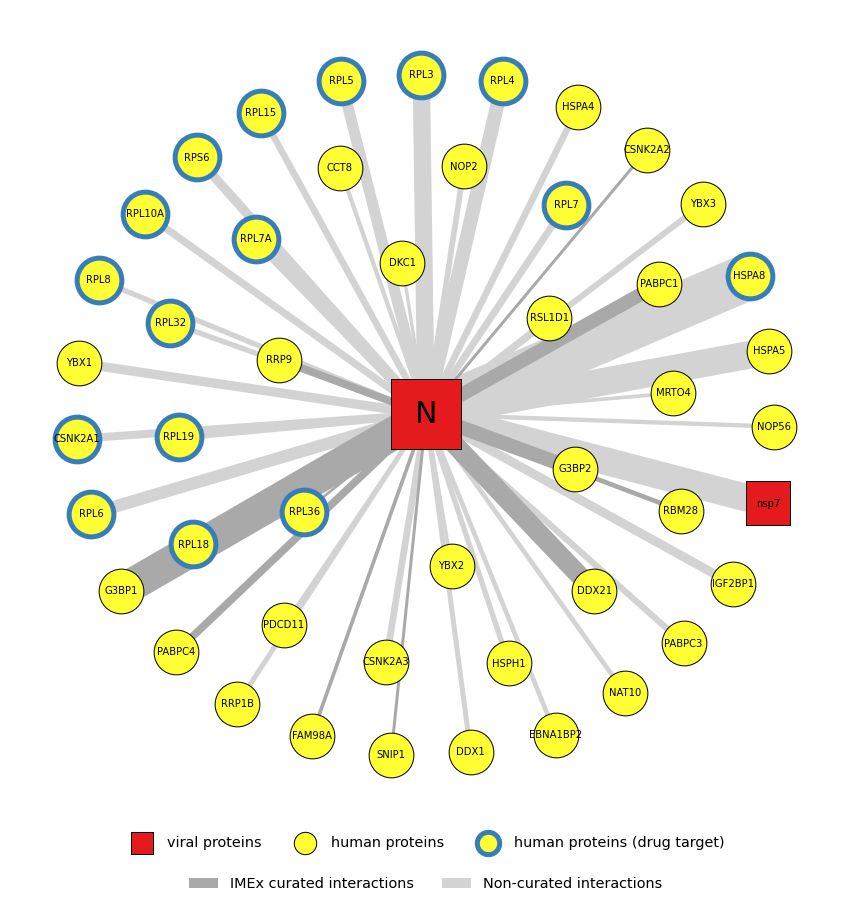

In [25]:
width = 15
height = width
fig, ax = plt.subplots(figsize=(width, height))

pos = nx.kamada_kawai_layout(ppi_network)

# Plot bait.
nx.draw_networkx_nodes(ppi_network, pos, node_size=5000, nodelist=[bait],
                       node_color='#e41a1c', node_shape='s',
                       edgecolors='black', ax=ax)
# Plot preys.
# SARS-CoV-2 preys.
nodelist_prey_sars_cov_2 = ppis_filtered_bait[
    ppis_filtered_bait['organism'] == 'SARS_CoV_2']['PreyGene'].unique()
nodes_sars_cov_2 = nx.draw_networkx_nodes(
    ppi_network, pos, node_size=2000, nodelist=nodelist_prey_sars_cov_2,
    node_color='#e41a1c', node_shape='s', edgecolors='black', ax=ax)
# Human preys.
nodelist_prey_human = ppis_filtered_bait[
    ppis_filtered_bait['organism'] == 'human']['PreyGene'].unique()
# Human preys that are drug targets.
nodelist_prey_human_drugs = ppis_filtered_bait[
    (ppis_filtered_bait['organism'] == 'human') &
    (ppis_filtered_bait['is_drug_target'])]['PreyGene'].unique()
nodes_human_drug = nx.draw_networkx_nodes(
    ppi_network, pos, node_size=2000, nodelist=nodelist_prey_human_drugs,
    node_color='#ffff33', node_shape='o', linewidths=5, edgecolors='#377eb8',
    ax=ax)
# Human preys that aren't drug targets.
nodelist_prey_human_nodrugs = ppis_filtered_bait[
    (ppis_filtered_bait['organism'] == 'human') &
    (~ppis_filtered_bait['is_drug_target'])]['PreyGene'].unique()
nodes_human_nodrug = nx.draw_networkx_nodes(
    ppi_network, pos, node_size=2000, nodelist=nodelist_prey_human_nodrugs,
    node_color='#ffff33', node_shape='o', edgecolors='black', ax=ax)

# Plot gene names.
nx.draw_networkx_labels(ppi_network, pos, {bait: bait}, font_size=30)
nx.draw_networkx_labels(
    ppi_network, pos, {prey: prey for prey in pos.keys() if prey != bait},
    font_size=10)

# Plot edges.
# Non-confirmed interactions.
edgelist_remaining = list(
    ppis_filtered_bait[~ppis_filtered_bait['is_curated']]
    [['Bait', 'PreyGene']].itertuples(index=False))
edges_remaining = nx.draw_networkx_edges(
    ppi_network, pos, edgelist_remaining, edge_color='lightgray',
    width=[ppi_network.edges[bait, prey]['AvgSpec']
           for bait, prey in edgelist_remaining])
# IMEx curated interactions.
edgelist_curated = list(
    ppis_filtered_bait[ppis_filtered_bait['is_curated']]
    [['Bait', 'PreyGene']].itertuples(index=False))
edges_curated = nx.draw_networkx_edges(
    ppi_network, pos, edgelist_curated, edge_color='darkgray',
    width=[ppi_network.edges[bait, prey]['AvgSpec']
           for bait, prey in edgelist_curated])

# Adjust margins.
x_values, y_values = zip(*pos.values())
x_min, x_max = min(x_values), max(x_values)
x_margin = (x_max - x_min) * 0.1
ax.set_xlim(x_min - x_margin, x_max + x_margin)
y_min, y_max = min(y_values), max(y_values)
y_margin = (y_max - y_min) * 0.1
ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Node legend.
node_legend = ax.legend(
    [nodes_sars_cov_2, nodes_human_nodrug, nodes_human_drug],
    ['viral proteins', 'human proteins', 'human proteins (drug target)'],
    loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3,
    fontsize='x-large', markerscale=0.5, frameon=False)
ax.add_artist(node_legend)
# Edge legend.
edge_legend = ax.legend(
    [edges_curated, edges_remaining],
    ['IMEx curated interactions', 'Non-curated interactions'],
    loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2,
    fontsize='x-large', markerscale=0.5, frameon=False)
for line in edge_legend.get_lines():
    line.set_linewidth(10)

sns.despine(left=True, bottom=True)

plt.savefig('ppi_network.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()